In [2]:
!pip install watermark
%load_ext watermark
%watermark

Last updated: 2024-08-15T22:17:45.778840+09:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 104 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



In [3]:
import pandas as pd
import metrics
import spaghetti
import sys, warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
try:
    from IPython.display import Markdown as md
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

C:\anaconda\Lib\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Watermark: 2.4.3

pandas    : 2.1.4
numpy     : 1.26.4
shapely   : 2.0.3
libpysal  : 4.10
spaghetti : 1.7.5.post1
matplotlib: 3.8.0
seaborn   : 0.12.2
geopandas : 0.14.3
json      : 2.0.9
sys       : 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
metrics   : 0.3.3
ortools   : 9.9.3963



In [4]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model.
        """
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """ Add an objective function to a model.
        """
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """record decision variable relationship
        folowing optimization.
        """
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """
        """
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """print select results
        """
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [5]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1)
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv) - 2)
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """object to mimic `model` when not present
            """

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [6]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=for_multiplot)
    
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )
    
def add_scale(base):
    """add a scale arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    bbox_props = dict(boxstyle="round, pad=.5", fc="w", ec="0.5", alpha=0.7)
    base.text(
        base.get_xlim()[0] + 75,
        base.get_ylim()[0] + 75,
        "|  ~.25km~  |",
        fontstyle="italic",
        bbox=bbox_props,
    )

In [7]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # empty legend spacing
    spacer = mpatches.Patch(edgecolor="None", facecolor="None", linewidth=0, label="")
    # all patches to add to legend
    patches = []
    # streets -- always plot
    strs = mlines.Line2D([], [], linewidth=2, alpha=1, label="Streets")
    patches.extend([spacer, strs])
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.extend([spacer, strbuff])
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.extend([spacer, cli_tru])
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.extend([spacer, fac_tru])
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.extend([spacer, cli_snp])
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.extend([spacer, fac_snp])
    patches.extend([spacer])
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([spacer, fdv, cdv, serv, spacer])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.extend([spacer, fdv, spacer])
    return patches

In [8]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "fuchsia",
        "mediumseagreen",
        "blueviolet",
        "darkslategray",
        "lightskyblue",
        "saddlebrown",
        "cyan",
        "darkgoldenrod",
        "limegreen",
        "peachpuff",
        "coral",
        "mediumvioletred",
        "darkcyan",
        "thistle",
        "lavender",
          "crimson",  # Add more colors as needed
        "darkorange",
        "teal",
        "indigo",
        "orchid",
        "olive",
        "peru",
        "salmon",
        "turquoise",
        "steelblue",
        "tomato",
        "sienna",
        "plum",
        "royalblue",
        "khaki",
        "indianred",
        "dodgerblue",
        "gold",
        "mediumaquamarine",
        "purple",
        "mediumslateblue",
        "seagreen",
        "darkkhaki",
        "lightcoral",
        "mediumturquoise",
        "slateblue",
        "chocolate",
        "lightsteelblue",
        "darkseagreen",
        "rosybrown",
        "mediumspringgreen",
        "skyblue",
        "navajowhite",
        "palegreen",
        "lightseagreen",
        "lightpink",
        "deepskyblue",
        "cadetblue",
        "orangered",
        "darkorchid",
        "darkturquoise",
        "lightgreen",
        "cadetblue",
        "mediumorchid",
        "darkolivegreen",
        "mediumblue",
        "lightslategray",
        "springgreen",
        "forestgreen",
        "darkmagenta",
        "dimgray",
        "hotpink",
        "mediumslateblue",
        "lime",
        "crimson",
        "orange",
        "greenyellow",
        "darkslateblue",
        "firebrick",
        "aquamarine",
        "burlywood",
        "lightsalmon",
        "goldenrod",
        "deepskyblue",
        "mediumspringgreen",
        "darkred",
        "darkviolet",
        "mediumseagreen",
        "lightgray",
        "slategray",
        "lawngreen",
        "blue",
        "mediumaquamarine",
        "yellow",
        "violet",
        "darkblue",
        "mediumvioletred",
        "orangered",
        "dodgerblue",
        "darkcyan",
        "lightseagreen",
        "coral",
        "purple",
        "olivedrab",
        "limegreen",
        "blueviolet",
        "mediumorchid",
        "gold",
        "darkorange",
        "darkslategray",
        "tomato",
        "darkkhaki",
        "darkgreen",
        "palevioletred",
        "darkmagenta",
        "forestgreen",
        "cadetblue",
        "lightblue",
        "green",
        "peru",
        "darksalmon",
        "deeppink",
        "turquoise",
        "mediumturquoise",
        "royalblue",
        "sienna",
        "saddlebrown",
        "teal",
        "darkslateblue",
        "chocolate",
        "navy",
        "springgreen",
        "rosybrown",
        "mediumblue",
        "darkorchid",
        "mediumslateblue",
        "indigo",
        "darkgoldenrod",
        "seagreen",
        "yellowgreen",
        "lightcoral",
        "darkviolet",
        "mediumspringgreen",
        "darkolivegreen",
        "deepskyblue",
        "mediumseagreen",
        "darkmagenta",
        "lightgreen",
        "lightskyblue",
        "lavender",
        "indianred",
        "darkturquoise",
        "blue",
        "mediumvioletred",
        "mediumaquamarine",
        "purple",
        "olivedrab",
        "darkgreen",
        "lightgray",
        "lightslategray",
        "cyan",
        "aquamarine",
        "lime",
        "darkred",
        "mediumorchid",
        "darkblue",
        "goldenrod",
        "lawngreen",
        "darkslategray",
        "slateblue",
        "cadetblue",
        "palegreen",
        "salmon",
        "olive",
        "darkcyan",
        "hotpink",
        "yellow",
        "firebrick",
        "mediumblue",
        "mediumslateblue",
        "dodgerblue",
        "orangered",
        "lightcoral",
        "lightseagreen",
        "lightslategray",
        "deeppink",
        "darkseagreen",
        "darkslateblue",
        "mediumturquoise",
        "mediumspringgreen",
        "turquoise",
        "palevioletred",
        "darkkhaki",
        "mediumorchid",
        "darkgoldenrod",
        "skyblue",
        "forestgreen",
        "darkviolet",
        "darkorchid",
        "springgreen",
        "limegreen",
        "saddlebrown",
        "mediumvioletred",
        "darkcyan",
        "thistle",
        "lavender",
        "crimson",  # Add more colors as needed
        "darkorange",
        "teal",
        "indigo",
        "orchid",
        "olive",
        "peru",
        "salmon",
        "turquoise",
        "steelblue",
        "tomato",
        "sienna",
        "plum",
        "royalblue",
        "khaki",
        "indianred",
        "dodgerblue",
        "gold",
        "mediumaquamarine",
        "purple",
        "mediumslateblue",
        "seagreen",
        "darkkhaki",
        "lightcoral",
        "mediumturquoise",
        "slateblue",
        "chocolate",
        "lightsteelblue",
        "darkseagreen",
        "rosybrown",
        "mediumspringgreen",
        "skyblue",
        "navajowhite",
        "palegreen",
        "lightseagreen",
        "lightpink",
        "deepskyblue",
        "cadetblue",
        "orangered",
        "darkorchid",
        "darkturquoise",
        "lightgreen",
        "cadetblue",
        "mediumorchid",
        "darkolivegreen",
        "mediumblue",
        "lightslategray",
        "springgreen",
        "forestgreen",
        "darkmagenta",
        "dimgray",
        "maroon",
    "darkslategray",
    "lightyellow",
    "darkorange",
    "lemonchiffon",
    "palegoldenrod",
    "goldenrod",
    "wheat",
    "rosybrown",
    "sandybrown",
    "firebrick",
    "darksalmon",
    "tomato",
    "coral",
    "orangered",
    "sienna",
    "brown",
    "chocolate",
    "saddlebrown",
    "peru",
    "darkgoldenrod",
    "gold",
    "darkkhaki",
    "khaki",
    "olive",
    "yellowgreen",
    "greenyellow",
    "chartreuse",
    "lawngreen",
    "greenyellow",
    "springgreen",
    "mediumspringgreen",
    "seagreen",
    "lightseagreen",
    "mediumseagreen",
    "darkseagreen",
    "forestgreen",
    "limegreen",
    "lime",
    "palegreen",
    "mediumaquamarine",
    "aqua",
    "cyan",
    "lightcyan",
    "paleturquoise",
    "mediumturquoise",
    "turquoise",
    "darkturquoise",
    "cadetblue",
    "steelblue",
    "lightsteelblue",
    "powderblue",
    "lightblue",
    "skyblue",
    "lightskyblue",
    "deepskyblue",
    "dodgerblue",
    "cornflowerblue",
    "royalblue",
    "mediumblue",
    "blue",
    "navy",
    "darkblue",
    "midnightblue",
    "slateblue",
    "darkslateblue",
    "mediumslateblue",
    "indigo",
    "darkorchid",
    "darkviolet",
    "mediumorchid",
    "orchid",
    "violet",
    "plum"


    ]
    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors
    
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    =======
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data
    
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv
    
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.s
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts
    
def analytics_matrix(mdls):
    """create stylized dataframe visualization of
    distance analytics
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style
    
def selection_matrix(mdls):
    """create stylized dataframe visualization of
    selected decision variables
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame.
        """
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style

In [9]:
from PyKakao import Local
api = Local(service_key = "3a4f78db357c6d41b1e84a632729668b")


import json
import requests
import geopandas as gpd

In [10]:
road = gpd.read_file('sig.shp', encoding = "cp949")

In [11]:
road.head(50)

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."
5,11230,Dongdaemun-gu,동대문구,"POLYGON ((962141.919 1956519.461, 962149.853 1..."
6,11260,Jungnang-gu,중랑구,"POLYGON ((965698.531 1957987.355, 965772.290 1..."
7,11290,Seongbuk-gu,성북구,"POLYGON ((956787.318 1953542.506, 956761.258 1..."
8,11305,Gangbuk-gu,강북구,"POLYGON ((956316.789 1965175.345, 956401.551 1..."
9,11320,Dobong-gu,도봉구,"POLYGON ((957223.835 1961199.545, 957195.758 1..."


In [12]:
ch_streets = road[road['SIG_CD'].str.startswith('4413')]

In [13]:
ch_streets

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
132,44131,"Dongnam-gu, Cheonan-si",천안시 동남구,"POLYGON ((981821.389 1876846.713, 981931.111 1..."
133,44133,"Seobuk-gu, Cheonan-si",천안시 서북구,"POLYGON ((965794.161 1885898.909, 965821.523 1..."


In [25]:
candidate = pd.read_csv("cancan.csv", encoding="utf8")
candidate = candidate.drop(20)

c2 = gpd.GeoDataFrame(candidate, geometry= gpd.points_from_xy(candidate['Longitude'], candidate['Latitude']), crs = 'EPSG:4326')
c2 = c2.to_crs("epsg:5179")
demand = pd.read_csv("demand_fin.csv", encoding="utf8")
d2 = gpd.GeoDataFrame(demand, geometry= gpd.points_from_xy(demand['Longitude'], demand['Latitude']), crs = 'EPSG:4326')
d22 = d2.to_crs("epsg:5179")

In [27]:
candidate.head(25)

,Unnamed: 0.1,Unnamed: 0,Title,Address,Longitude,Latitude,행정동,geometry,x,y
0,0,0,카페이숲,충남 천안시 서북구 성거읍 남창마을1길 32 1층,127.195422,36.862185,성거읍,POINT (972850.988752277 1873812.503410197),972850.988752,1.873813e+06
1,1,1,블렌데렌,"충남 천안시 동남구 먹거리8길 5 1, 2층",127.194310,36.804880,신부동,POINT (972731.5274605945 1867455.990715825),972731.527461,1.867456e+06
2,2,2,그리고스페셜티,충남 천안시 동남구 유량로 104,127.172754,36.807128,원성1동,POINT (970809.5413484469 1867711.7166895212),970809.541348,1.867712e+06
3,3,3,오월의숲,충남 천안시 서북구 세관길 78,127.145208,36.823195,성정2동,POINT (968358.9866906875 1869502.8197424544),968358.986691,1.869503e+06
4,4,4,유얼스,충남 천안시 서북구 불당31길 37,127.105355,36.810215,불당2동,POINT (964798.8921061844 1868076.9081344209),964798.892106,1.868077e+06
5,5,5,풍세커피,충남 천안시 동남구 풍세면 한우물2길 90 2동 1층,127.106483,36.740875,풍세면,POINT (964867.8870737354 1860384.562381759),964867.887074,1.860385e+06
6,6,6,교토리,충남 천안시 동남구 북면 위례성로 782,127.271452,36.831803,북면,POINT (979619.9518166382 1870423.2899334442),979619.951817,1.870423e+06
7,7,7,피노카페,충남 천안시 동남구 풍세면 휴양림길 99-23,127.092564,36.729021,풍세면,POINT (963619.6647176059 1859074.866708052),963619.664718,1.859075e+06
8,8,8,마리스,충남 천안시 동남구 천호지길 11,127.172957,36.834352,신안동,POINT (970837.9803121027 1870731.6830188802),970837.980312,1.870732e+06
9,9,9,마젠타,충남 천안시 서북구 성성2길 81 1동 2~4층,127.129597,36.846493,부성2동,POINT (966976.7984331299 1872092.5510918086),966976.798433,1.872093e+06


In [33]:
# n clients and n facilities
client_count, facility_count = 23,289

# candidate facilites to site
p_facilities = 5

# maximum coverage meters
max_coverage = 600.0

# minimum coverage meters
min_coverage = 300.0

title = "Neighborhood X"
ch_clients = d22
ch_clients.shape

(23, 7)

In [35]:
buff = 20
streets_buffer = get_buffer(ch_streets, buff=buff)
streets = ch_streets

#구분자 삽입
clients = d22
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = c2
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities

}

In [37]:
# 네트워크 불러오기

ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)
# Cost Matrix 계산 시간 소요
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[4713.99158219, 2975.96551611, 2997.56433756],
       [8442.47009629,  752.51298494,  730.91415892],
       [4556.20317229, 5620.48646477, 5642.08528622]])

Solve Time: 0.0033500067000000002 minutes
Obj. Value: 5.225965292547496 residents within 300.000000 meters of 5 selected facilities
Percent of 11 clients covered: 45.670804
--- 17 clients are not covered
--- 6 clients are covered by 1 facility


AttributeError: 'list' object has no attribute 'tolist'

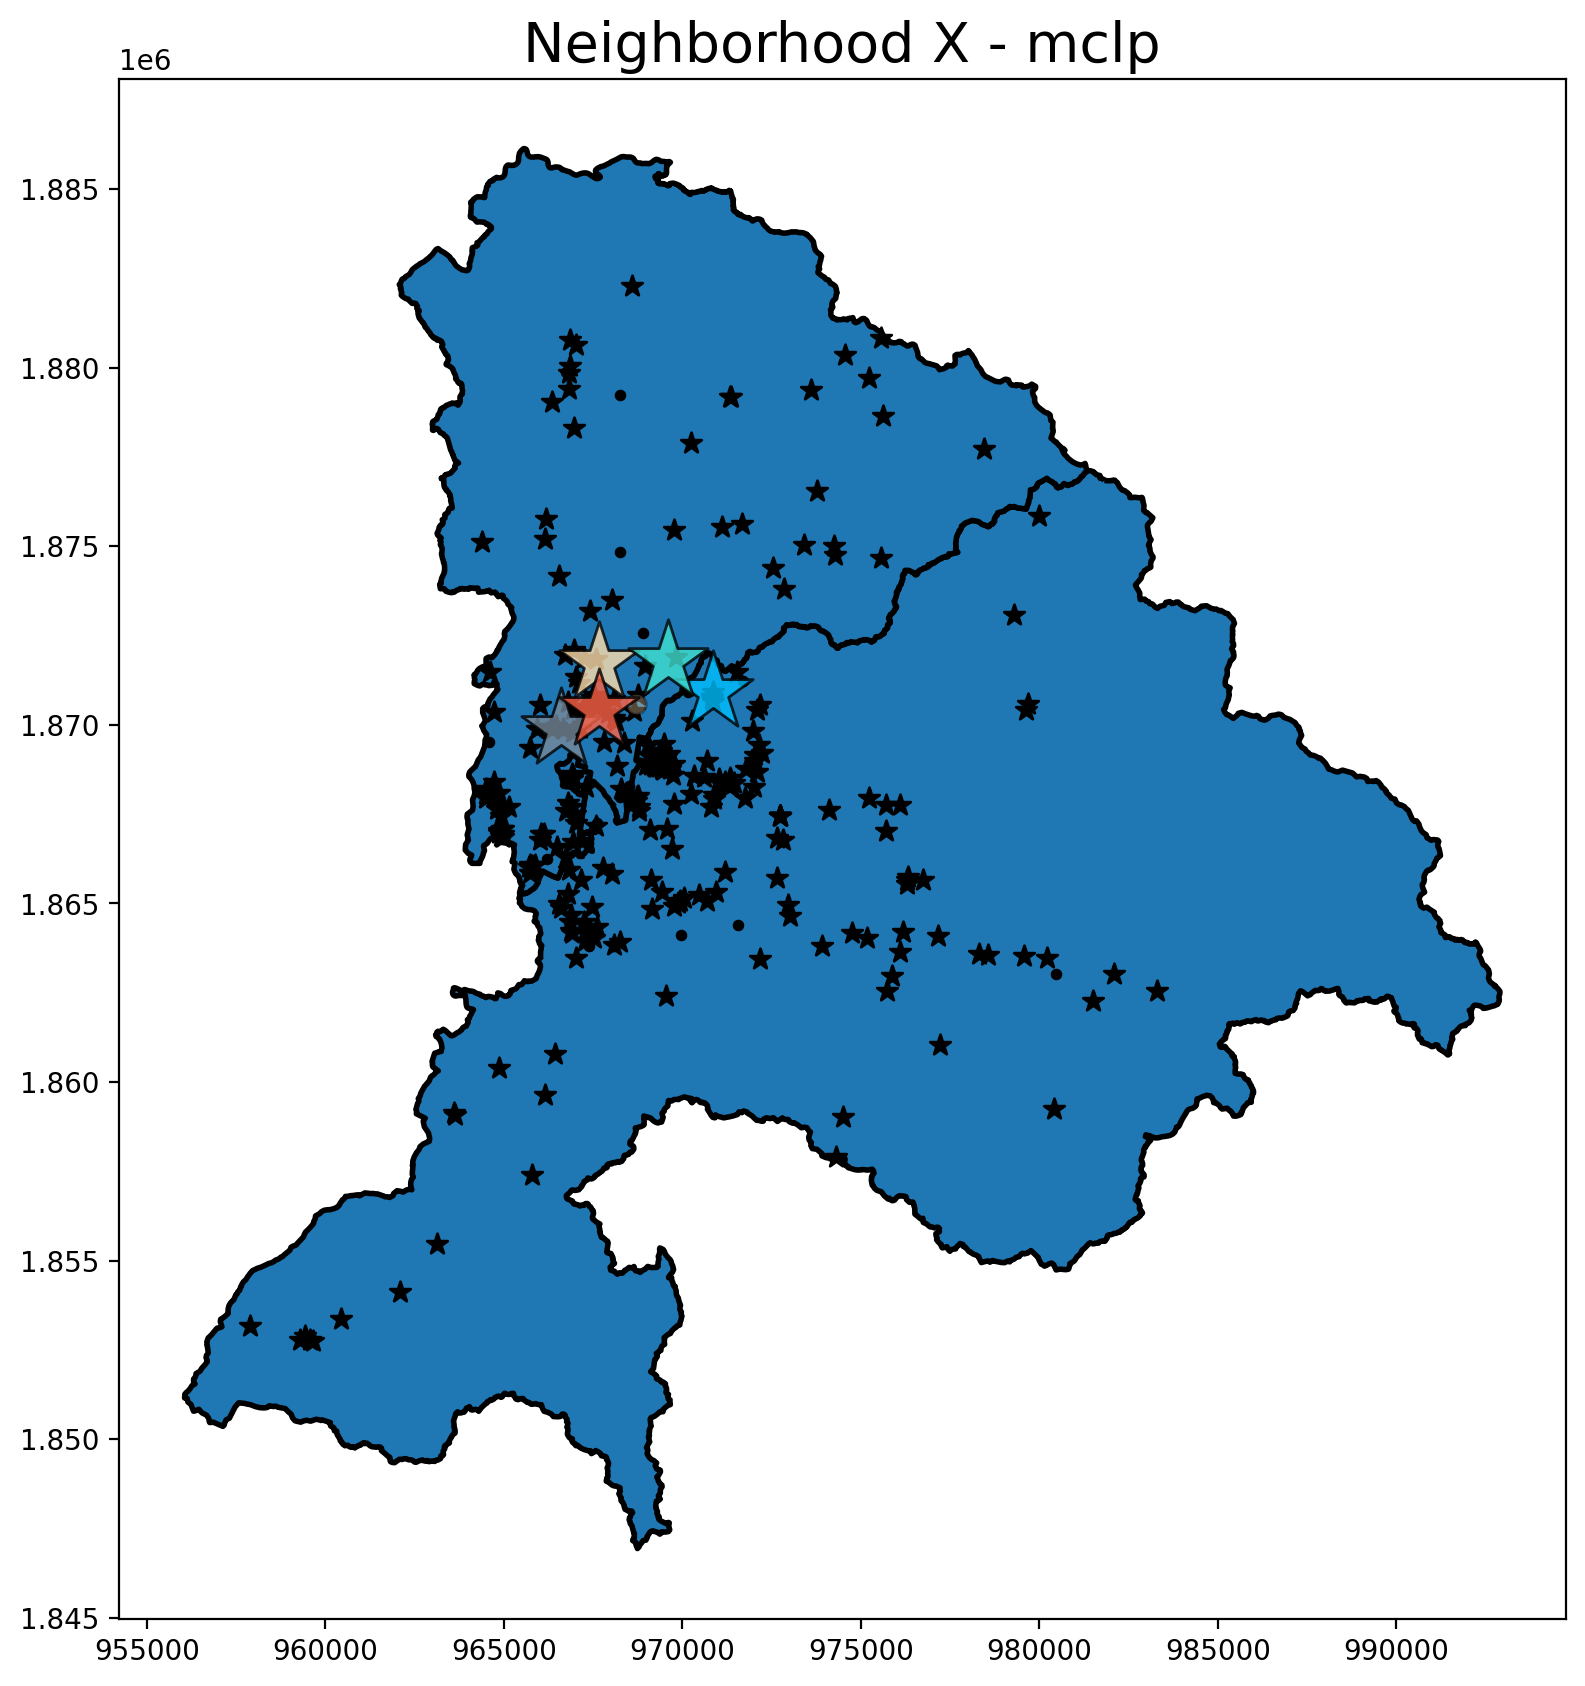

In [39]:
mclp = FacilityLocationModel(
    "mclp", ai=d22["weighted_distance"], cij=cost_matrix, p=5, s=300
)
clients, facilities = add_results(mclp, clients, facilities)
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

Solve Time: 0.0033500067000000002 minutes
Obj. Value: 8.601223788963376 residents within 900.000000 meters of 5 selected facilities
Percent of 11 clients covered: 75.167894
--- 9 clients are not covered
--- 14 clients are covered by 1 facility


NameError: name 'add_legend' is not defined

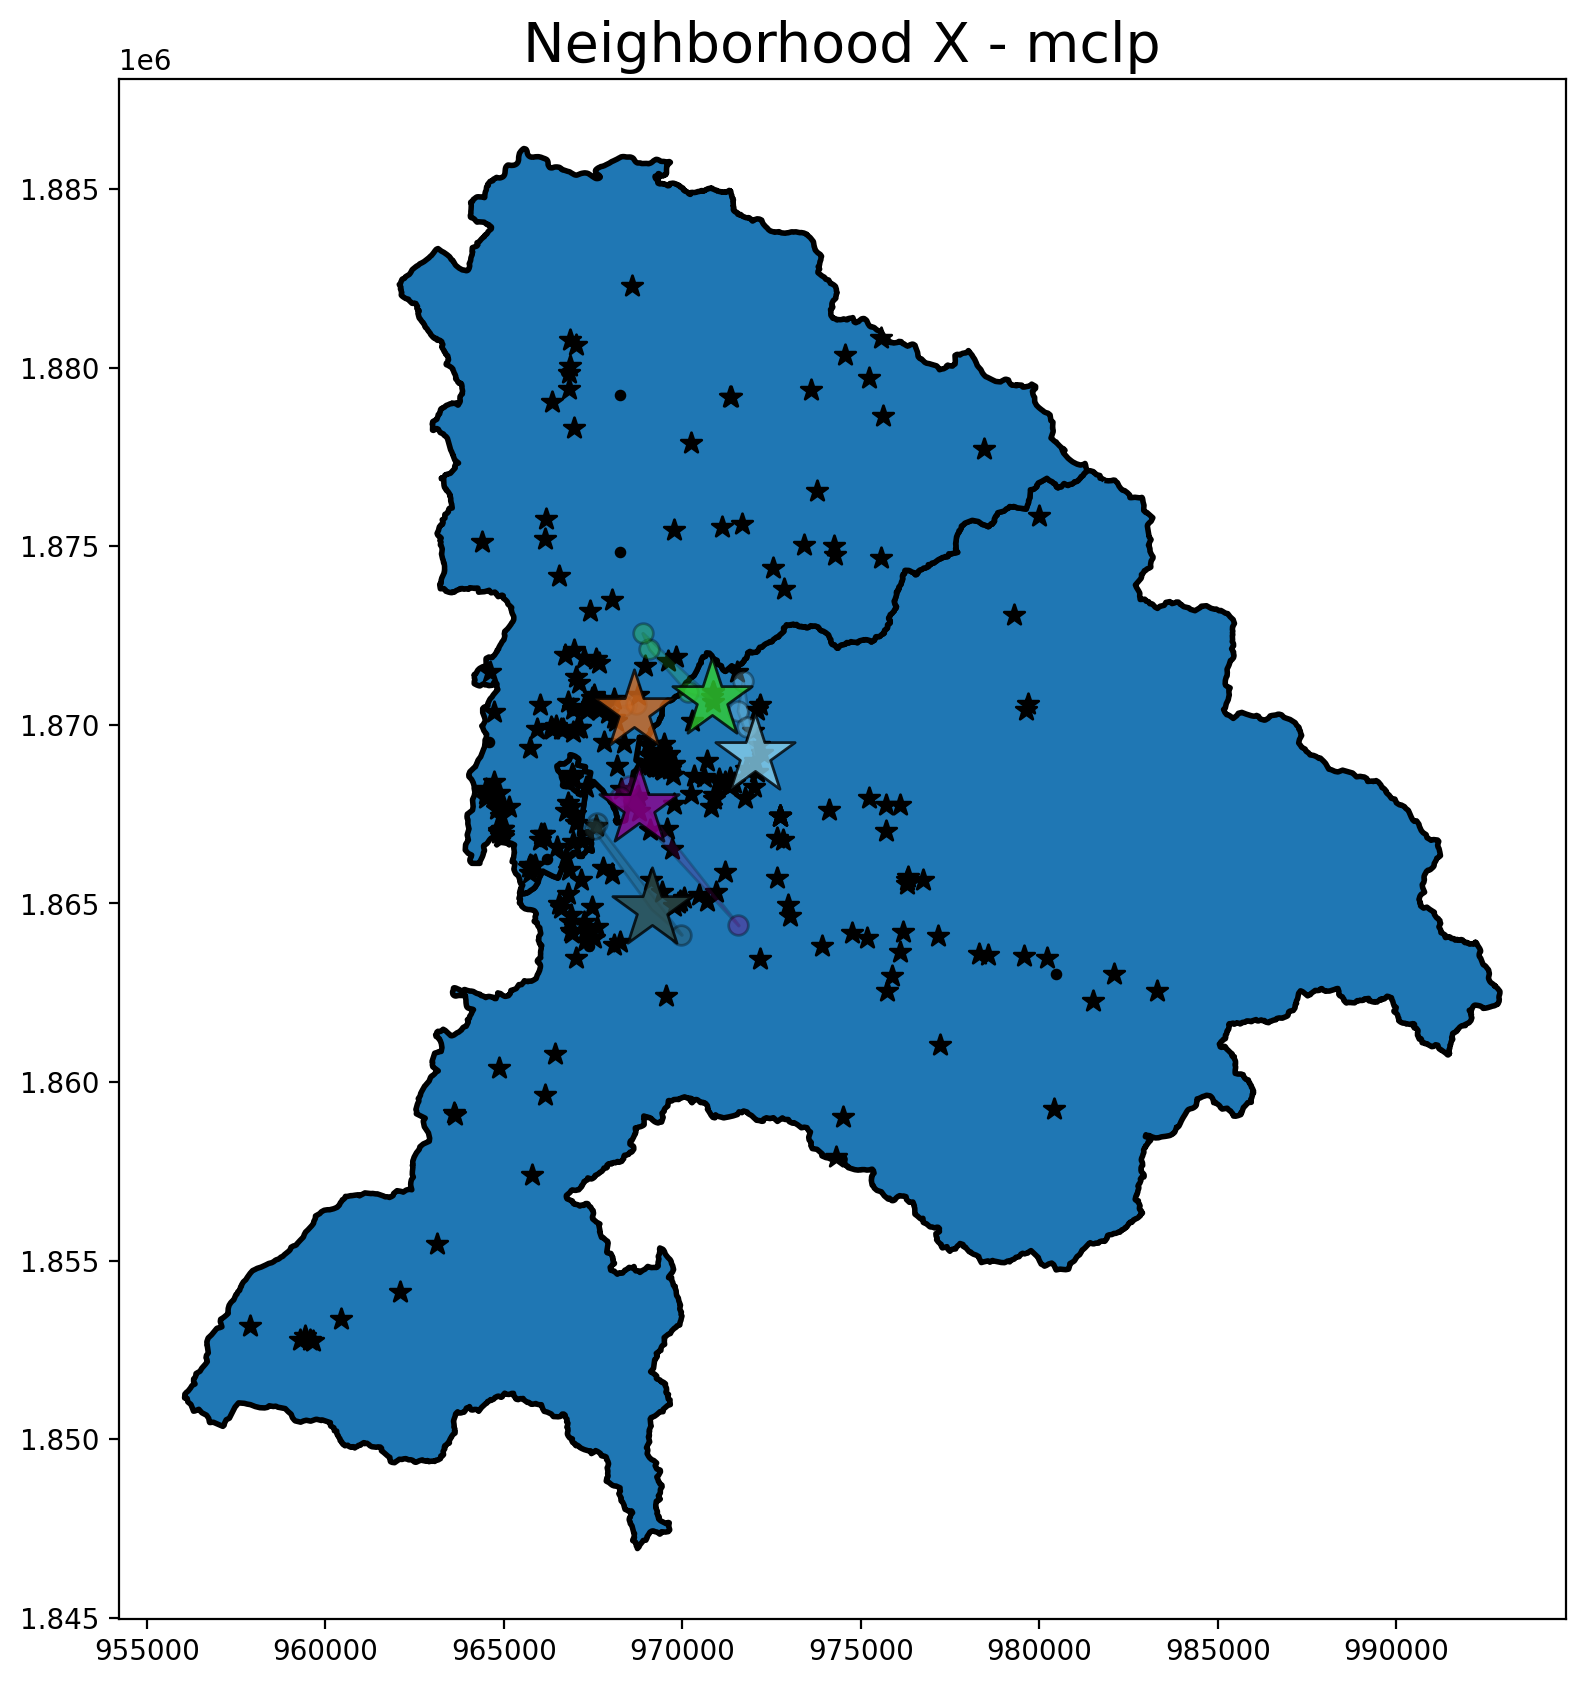

In [41]:
mclp = FacilityLocationModel(
    "mclp", ai=d22["weighted_distance"], cij=cost_matrix, p=5, s=900
)
clients, facilities = add_results(mclp, clients, facilities)
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

Solve Time: 0.0032833399 minutes
Obj. Value: 11.43381148359036 residents within 3800.000000 meters of 5 selected facilities
Percent of 11 clients covered: 99.922470
--- 1 clients are not covered
--- 22 clients are covered by 1 facility
--- 2 clients are covered by 2 facilities


NameError: name 'add_legend' is not defined

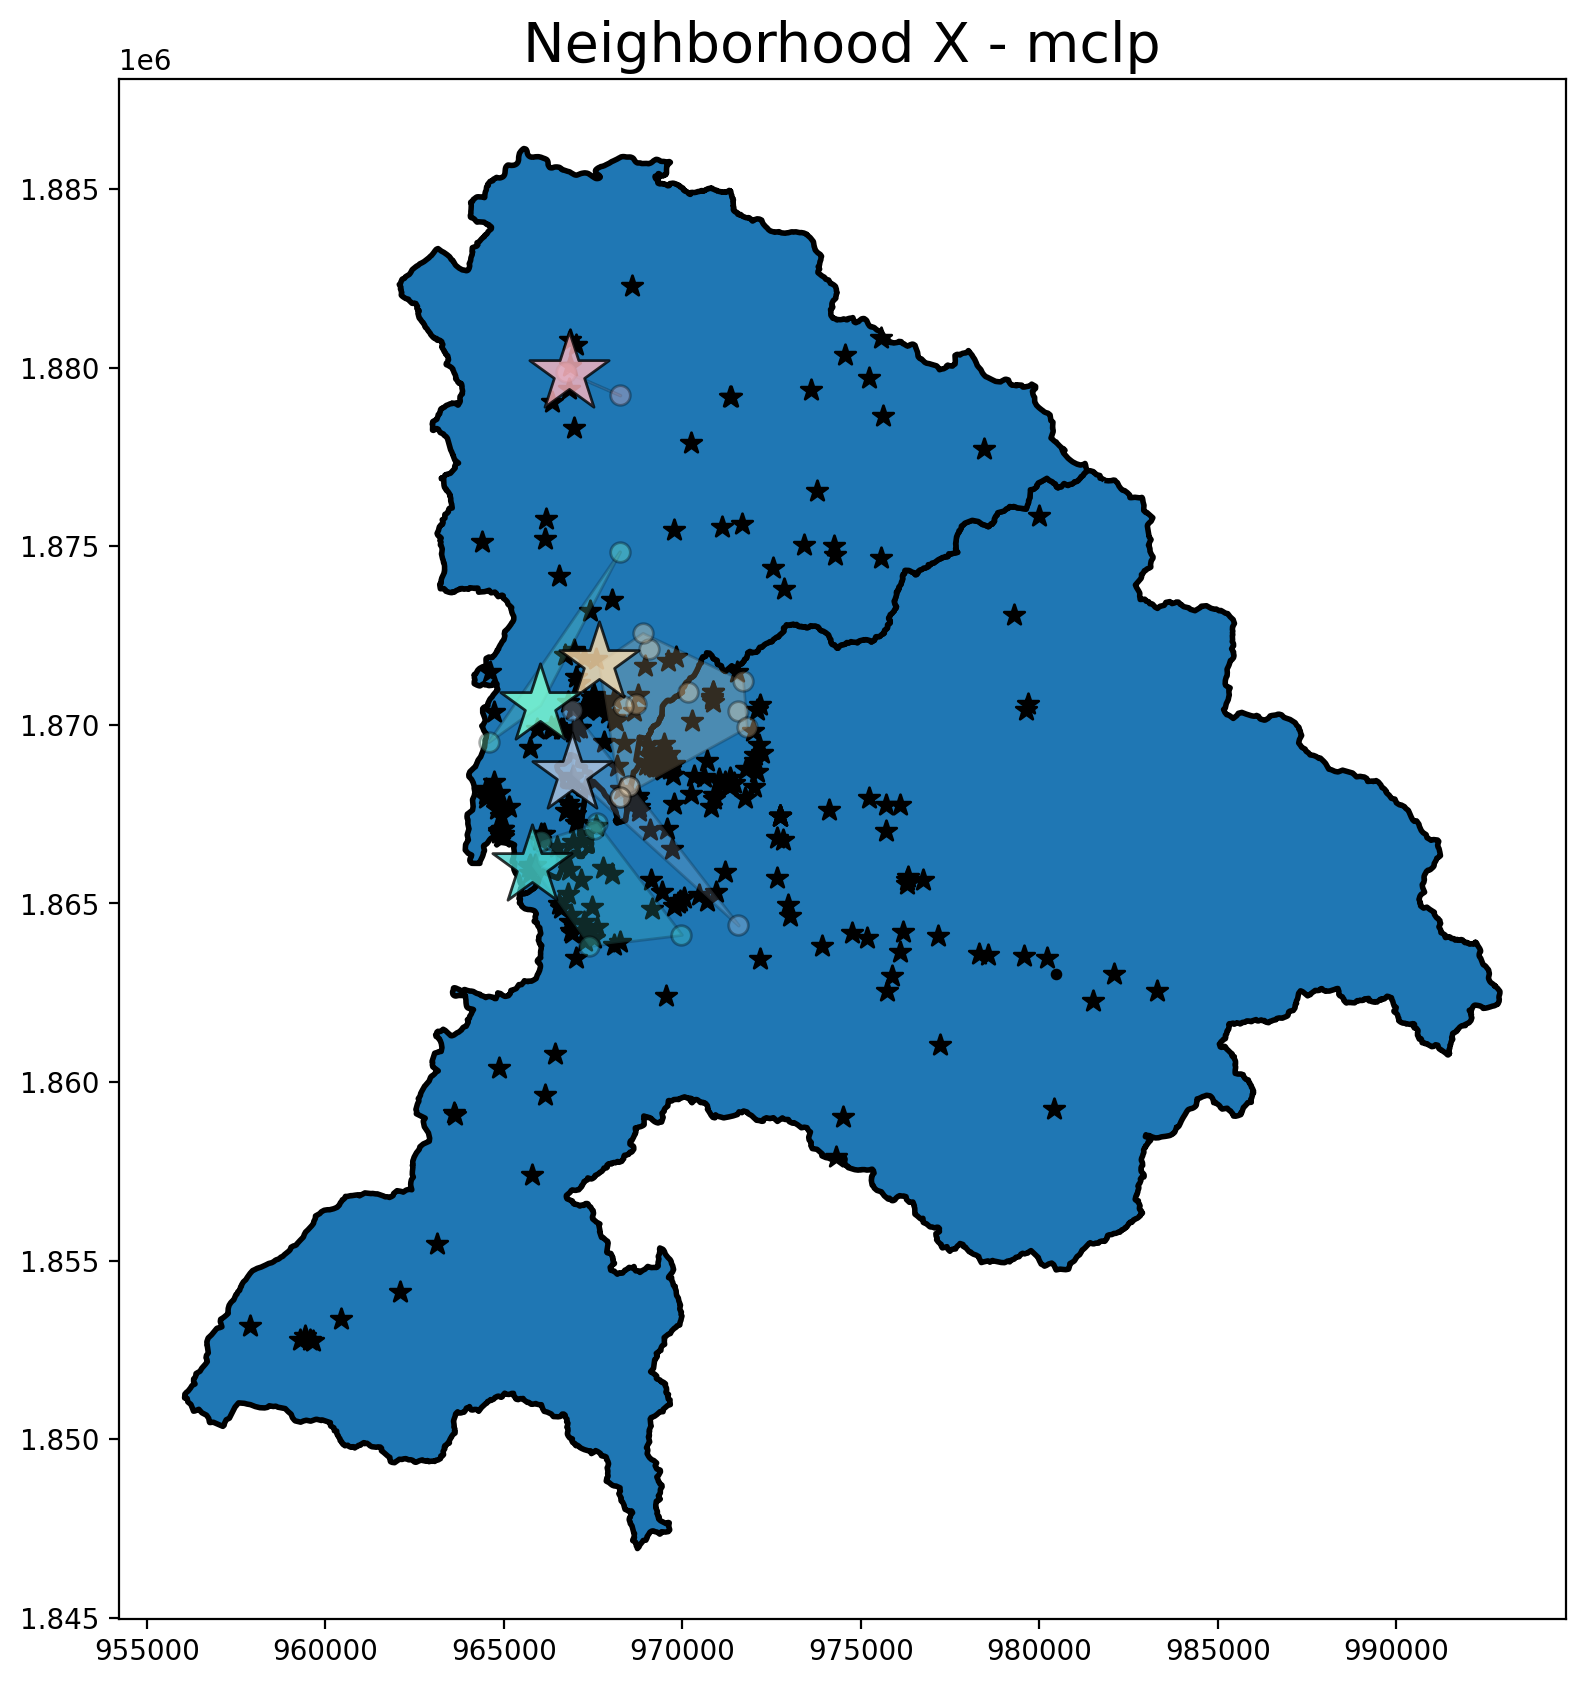

In [43]:
mclp = FacilityLocationModel(
    "mclp", ai=d22["weighted_distance"], cij=cost_matrix, p=5, s=3800
)
clients, facilities = add_results(mclp, clients, facilities)
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [45]:
facilities[facilities["mclp_sol"] != "closed"][["Title", "Address","행정동","dv", "geometry"]]

,Title,Address,행정동,dv,geometry
43,카페 루,충남 천안시 동남구 서부대로 531-20,봉명동,y[42],POINT (966917.196 1868611.598)
48,릴리프,충남 천안시 서북구 성성11길 24-1 1층,부성2동,y[47],POINT (967661.969 1871734.060)
75,H카페,충남 천안시 서북구 한들1로 120,백석동,y[74],POINT (966014.219 1870561.243)
119,코네로,충남 천안시 서북구 월봉5길 33 1층,쌍용2동,y[118],POINT (965786.247 1866060.266)
237,925개러지카페,"충남 천안시 서북구 성환읍 성환1로 243 주윤빌딩 1층 108,109호",성환읍,y[236],POINT (966834.872 1879853.908)


Solve Time: 0.0041833417 minutes
Obj. Value: 11.44268296025096 residents within 3800.000000 meters of 6 selected facilities
Percent of 11 clients covered: 100.000000
--- 0 clients are not covered
--- 23 clients are covered by 1 facility
--- 2 clients are covered by 2 facilities


AttributeError: 'list' object has no attribute 'tolist'

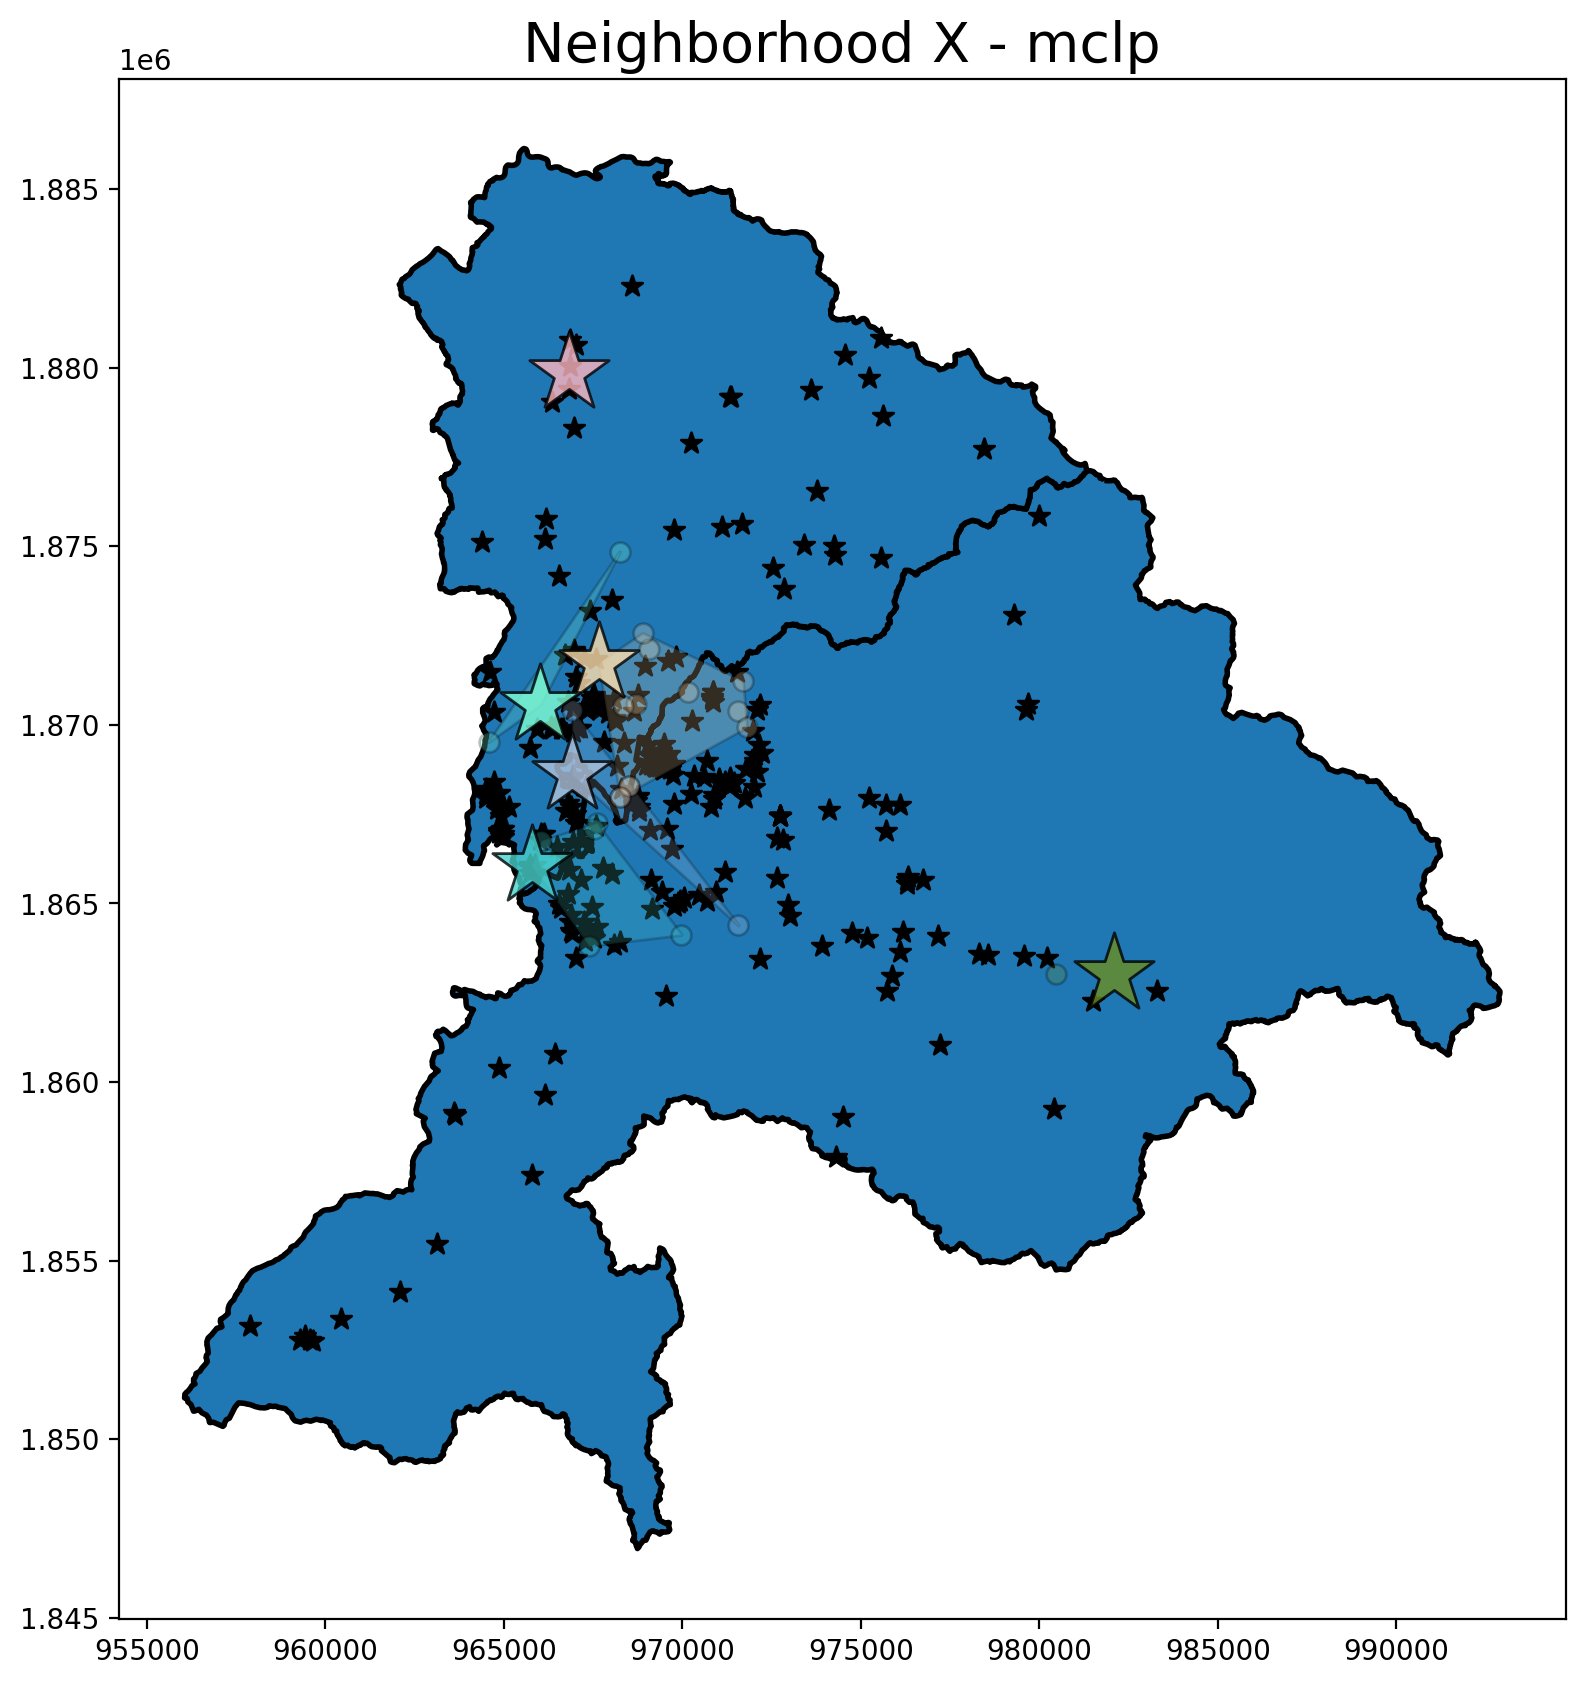

In [47]:
mclp = FacilityLocationModel(
    "mclp", ai=d22["weighted_distance"], cij=cost_matrix, p=6, s=3800
)
clients, facilities = add_results(mclp, clients, facilities)
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [49]:
facilities[facilities["mclp_sol"] != "closed"][["Title", "Address","행정동","dv", "geometry"]]

,Title,Address,행정동,dv,geometry
43,카페 루,충남 천안시 동남구 서부대로 531-20,봉명동,y[42],POINT (966917.196 1868611.598)
48,릴리프,충남 천안시 서북구 성성11길 24-1 1층,부성2동,y[47],POINT (967661.969 1871734.060)
75,H카페,충남 천안시 서북구 한들1로 120,백석동,y[74],POINT (966014.219 1870561.243)
119,코네로,충남 천안시 서북구 월봉5길 33 1층,쌍용2동,y[118],POINT (965786.247 1866060.266)
152,카페크렘므,충남 천안시 동남구 병천면 아우내3로 33 1층,병천면,y[151],POINT (982077.021 1863036.712)
237,925개러지카페,"충남 천안시 서북구 성환읍 성환1로 243 주윤빌딩 1층 108,109호",성환읍,y[236],POINT (966834.872 1879853.908)
